# Final Project: Audio Command Detection


### Group Members:
**Aida Ahmadi Parsa, Emelin Ghazarian, Zahra Latifi, Maryam Moghtaderi**

### Attribution:
**This code is based on a Tensorflow tutorial, for simple audio recegnition. The code uses an open-source dataset consisting of 1-second-length samples, and it detects 8 commands.**

Link to the reference project: https://www.tensorflow.org/tutorials/audio/simple_audio

### Notes:
**We have modified the reference code so that it uses 3-second-length mono-channel .wav files with a sample rate of 16KHz as dataset, and is compatible for smaller datasets. The dataset is manually recorded and is based on the audio data from 13 different voices.**

**The final pieces of code (Part3) are also added to test the project using a real-time mirophone experiment.**


## Step 1:
We first import libraries we will need through the process.
Some of these libraries/packages include:
1. Tensorflow: Used for building and training our CNN Model
2. Seaborn: A proffesional matplotlib-based tool, for data visualization
3. pyaudio: Used to collect real-time data from microphone
4. librosa: A python package for music and audio analysis

In [1]:
#Import Libraries and packages
import os
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display
import librosa
import pyaudio
import sys

## Step 2:
We initialize the random number generator for Tensorflow and Numpy, in order to precieve reproducibilty

In [2]:
#Initialize the random number generator.
# Set the seed value for experiment reproducibility.
seed = 40
tf.random.set_seed(seed)
np.random.seed(seed)

## Step 3:
We have uploaded our dataset to a link as a .zip file, and we need to download and unzip it to the right directory.
This step is run ***only once*** and we will use the address to refer to the directory in next steps.

### Notes:
The dataset consists of 420 samples in .wav format (i.e. 105 samples for each of the four classes).
The recorded samples are converted into 16000Hz, mono-channel files using **FFmpeg** tool in cmd.

<span style="color:red">ATTENTION: DO NOT RUN THIS CELL MORE THAN ONCE:</span>

In [45]:
#Download .zip file and unzip it in data directory
DATASET_PATH = 'datasetdir2/dataset'
data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
  tf.keras.utils.get_file(
      'dataset.zip',
      origin="https://s8.uupload.ir/filelink/fEWlM65qSHQh_dabdf91cd9/dataset_kij6.zip",
      extract=True,
      cache_dir='.', cache_subdir='datasetdir2')

28161926/28161926 [==============================] - 97s 3us/step


## Step 4:
Each class's data samples are saved in a separate folder inside the .zip file. We can extract the name of the folders to build our **Commands** array, indicating the commands we will use in the project.

In [17]:
#Extracting command, using the names of folders in our data directory
file_path = 'C:\\Users\\Berooz Stock\\datasetdir2'
commands = np.array(tf.io.gfile.listdir(str(file_path)))

#Making sure the .zip file name is not counted as a command
commands = commands[(commands != 'dataset.zip') & (commands !='.ipynb_checkpoints')]

#printing command array to be checked
print('Commands:', commands)

Commands: ['down' 'left' 'right' 'up']


## Step 5:
Now, we generate a TensorFlow dataset from audio files stored in our directory. 

We have used a batch size of 32, and each output sequence consists of 48000 bits, which is because we have 3 seconds of 16000Hz audio.

80% of total samples are used for training, and the rest are used for validation.

In [18]:
#Generate a TensorFlow dataset from audio files stored in the directory
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=file_path,
    batch_size=32,
    validation_split=0.2,
    seed=0,
    output_sequence_length=3*16000,
    subset='both')

#Extracting lable names based on our classes, and printing the lables array
label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 656 files belonging to 4 classes.
Using 525 files for training.
Using 131 files for validation.

label names: ['down' 'left' 'right' 'up']


## Step 6:

The purpose of the **squeeze** function is to remove the last dimension of the audio tensor, which has size 1 and is not needed for the subsequent processing. This can help reduce the memory footprint of the model and improve the training speed. Note that the squeeze function is applied using the map method, which applies a given function to each element of the dataset in parallel, making it an efficient way to preprocess large datasets.

In [19]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

#Apllying to our dataset
train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

#Getting an example from our samples
for example_audio, example_labels in train_ds.take(1):  
  print(example_audio.shape)
  print(example_labels.shape)

(32, 48000)
(32,)


## Step 7: Checkpoint!
<span style="color:Blue">Let's plot the first 9 samples from our dataset as waveforms</span>

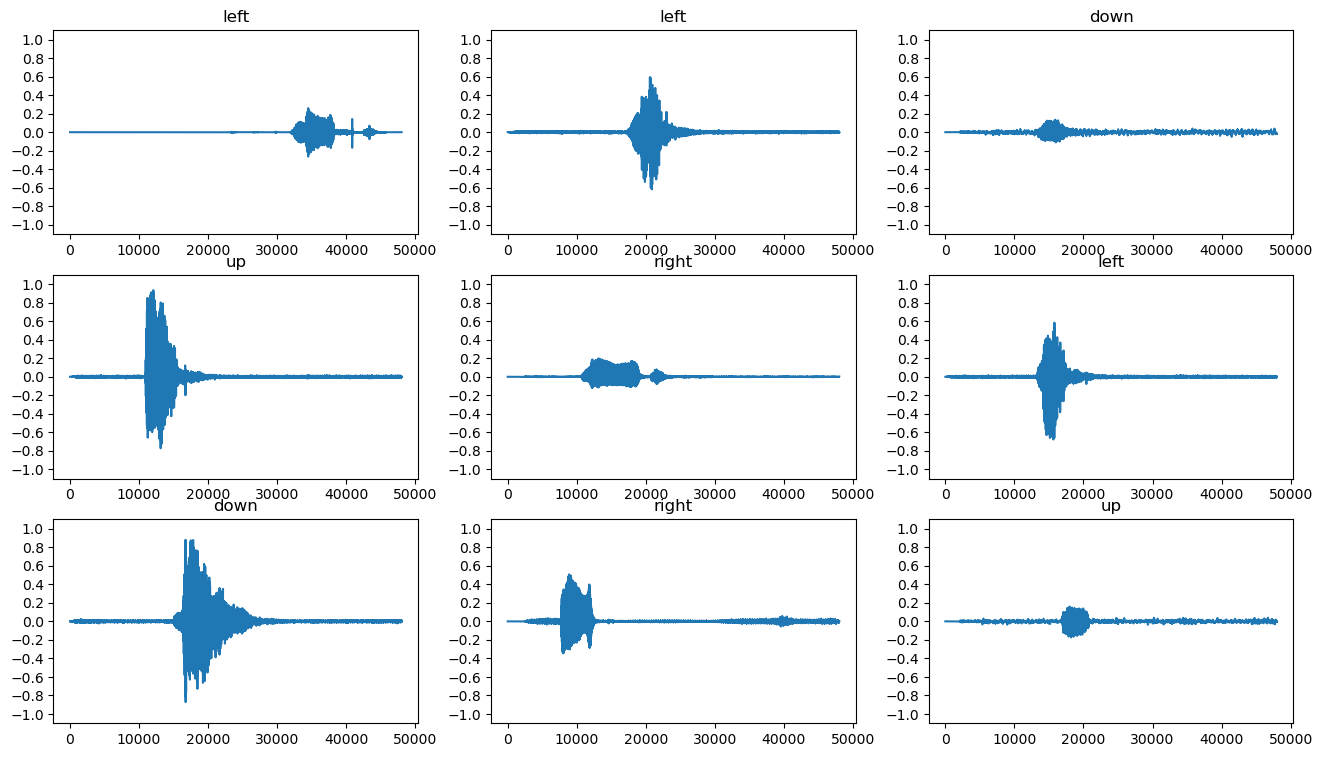

In [20]:
#Defining the number of columns and rows and making our subplot
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

#Plotting waveforms
for i in range(n):
  if i>=n:
    break
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(example_audio[i].numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label_names[example_labels[i]]
  ax.set_title(label)
  ax.set_ylim([-1.1,1.1])
plt.show()

## Step 8:
In this step, we define a function that converts a waveform signal to a spectrogram representation:

In [21]:
def get_spectrogram(waveform):
  # Converting the waveform to a spectrogram via a STFT (Short-Time Fourier Transform)
  spectrogram = tf.signal.stft(
      waveform, frame_length=512, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used as image-like input data with convolution layers
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

## Step 9: Checkpoint!
<span style="color:Blue">Let's check out some of the audio samples and their corresponding waveform and spectogram shapes!</span>

In [22]:
for i in range(3):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=16000))

Label: left
Waveform shape: (48000,)
Spectrogram shape: (372, 257, 1)
Audio playback


Label: left
Waveform shape: (48000,)
Spectrogram shape: (372, 257, 1)
Audio playback


Label: down
Waveform shape: (48000,)
Spectrogram shape: (372, 257, 1)
Audio playback


## Step 10:
We now define a function that plots a spectrogram using the matplotlib library. Here's what each part of the function does:

1. The function plot_spectrogram takes two arguments: spectrogram, which is a 2D or 3D numpy array representing the spectrogram, and ax, which is the matplotlib axis object on which the spectrogram will be plotted.

2. The first if statement checks if the input spectrogram is a 3D array and if so, squeezes it along the last dimension using the np.squeeze function. This is because some spectrograms may have an extra dimension.

3. The next line of code converts the frequencies to a log scale and transposes the spectrogram, so that the time is represented on the x-axis and the frequency is represented on the y-axis. This is done using np.log and the transpose operator .T, respectively. An epsilon is added to the spectrogram before taking the log to avoid taking the log of zero.

4. The dimensions of the log spectrogram are then extracted using the shape attribute, and the linspace function is used to create a vector X representing the time axis values for the spectrogram. The num argument specifies the number of values to generate, which is equal to the width of the spectrogram.

5. The range function is used to create a vector Y representing the frequency axis values for the spectrogram. The length of Y is equal to the height of the spectrogram.

6. Finally, the pcolormesh function of the matplotlib axis object is used to plot the log spectrogram on the specified axis ax. This function creates a pseudo-color plot of the spectrogram, where each cell in the plot corresponds to a frequency-time bin in the spectrogram. The X, Y, and log_spec arrays are used as inputs to the pcolormesh function to specify the x-axis, y-axis, and color values, respectively.

In [23]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

This example is how this function works:

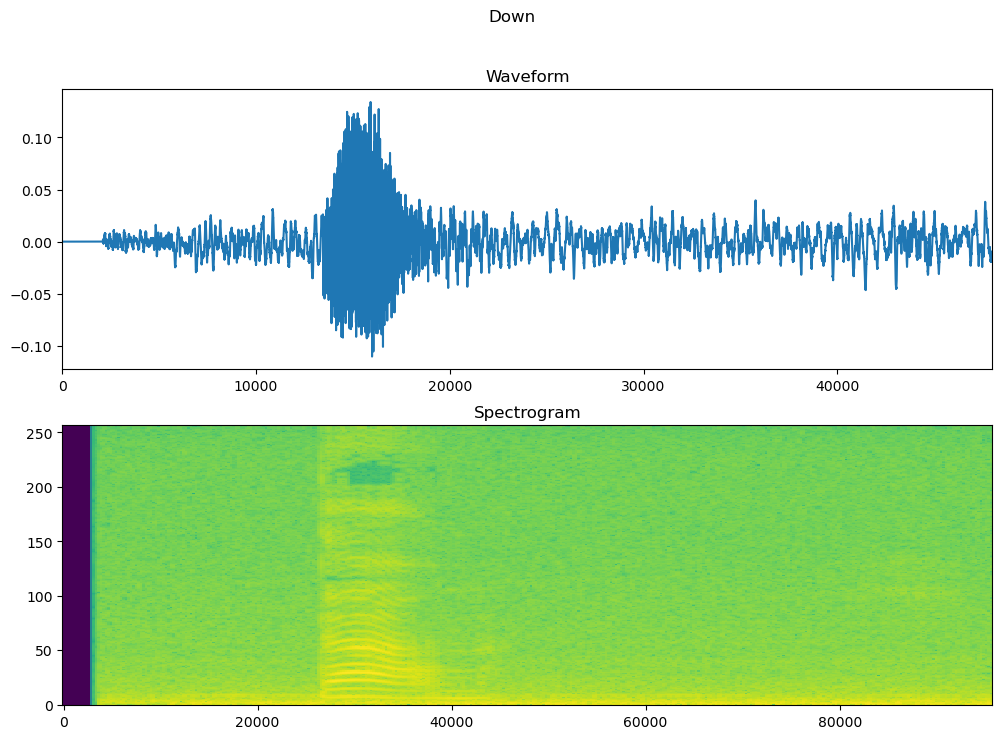

In [24]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 48000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

## Step 11:
We define a function which takes a dataset ds as input and applies a mapping function to each element of the dataset using the map function. The mapping function takes an audio waveform and a label as input, and returns a tuple of the spectrogram and label.

In [25]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

## Step 12:
Now we use the above function to create our spectrogram datasets for training and validation

In [26]:
#creating new datasets with spectrograms
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

#Getting an example from our spectrograms
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

## Step 13: Checkpoint!
<span style="color:Blue">Let's check out some of the spectrograms from our samples</span>

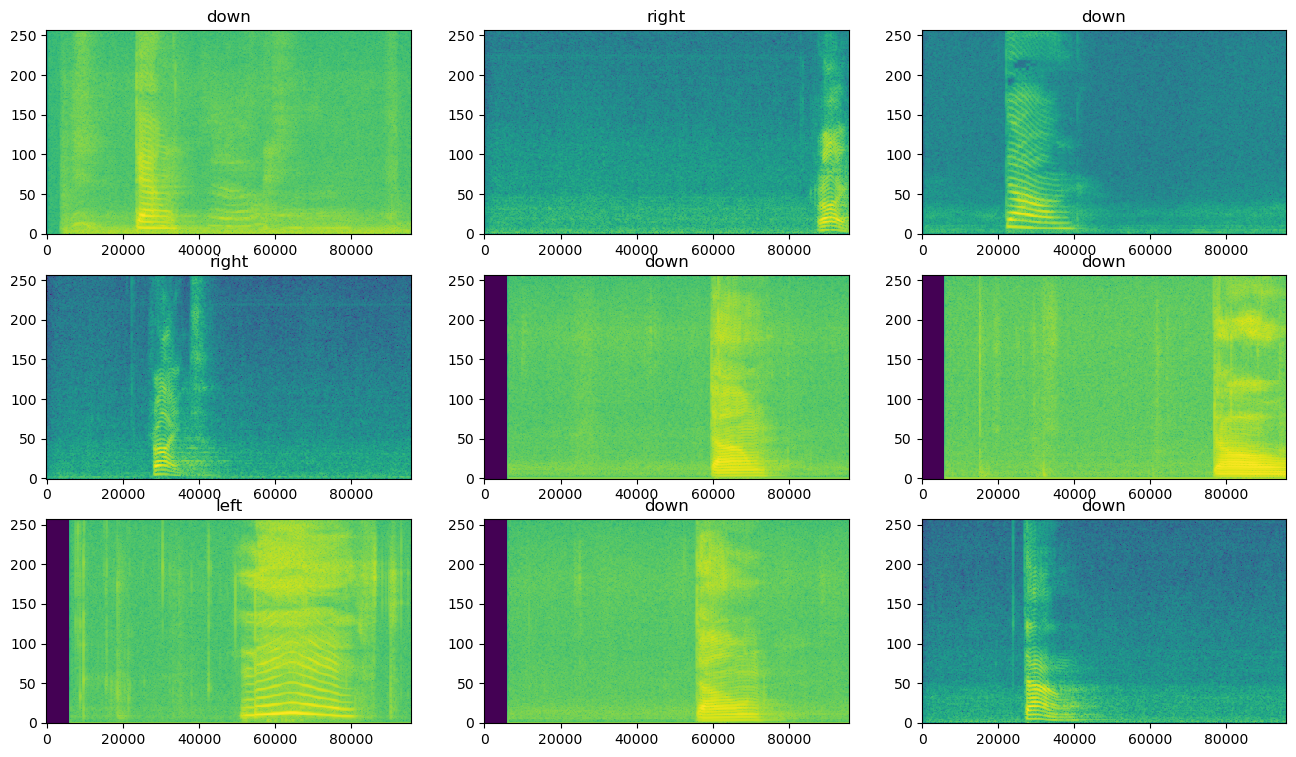

In [28]:
#Defining the number of columns and rows and making our subplotrows = 3
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

#Plotting the spectrograms
for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()

## Part 2: Training The CNN Model

## Step 1:
We now perform caching, shuffling, and prefetching on the spectrogram datasets created earlier:

1. The cache function is called on the train_spectrogram_ds and val_spectrogram_ds datasets. This caches the elements of the dataset in memory or on disk (depending on available resources) after they are loaded for the first time. This can improve the performance of the dataset by avoiding the need to load the data from disk or compute the spectrograms again for each epoch.

2. The shuffle function is called on the train_spectrogram_ds dataset with a buffer size of 500. This shuffles the elements of the dataset randomly, with a buffer size of 500 elements used for the shuffling process. This can help to randomize the order of the elements and avoid overfitting to the order of the data.

3. The prefetch function is called on both the train_spectrogram_ds and val_spectrogram_ds datasets with the tf.data.AUTOTUNE argument. This prefetches elements from the dataset in the background while the model is training, allowing the data to be loaded more efficiently and reducing the time spent waiting for data to become available. The tf.data.AUTOTUNE argument allows TensorFlow to automatically determine the optimal number of elements to prefetch based on available computational resources.

In [29]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(500).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

## step 2:
Here comes the tricky part, which we build a sequential model for our CNN, using Tensorflow's Keras API!

As the dataset is not too large, making a very complex model would potentially result in overfitting. So, we try to keep our model as simple as possible. Note that the Dropout layers are also used to reduce the chance of overfitting.


In [30]:
#Getting the shape of the input spectrograms
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)

#Getting the number of labels
num_labels = len(label_names)

# Instantiating the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()

# Fitting the state of the layer to the spectrograms with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

#Adding the desired layers to our model
model = models.Sequential([
    layers.Input(shape=input_shape),
    # Normalize.
    #norm_layer,
    
    layers.Conv2D(24, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    #layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_labels),
])

# Printing out the summary of the created model
model.summary()

Input shape: (372, 257, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 370, 255, 24)      240       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 185, 127, 24)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 183, 125, 32)      6944      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 91, 62, 32)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 91, 62, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           

## Step 3:
We compile the created model, using Adam optimizer.

In [31]:
#Compiling model
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

# Step 4:
We define 10 epochs to fit our model with, using previously created datasets for validateion and training.

**Note:**
By defining patience=3, the early stopping occurs when loss is not improved after processing 3 epochs in a row.

In [32]:
#Defining the number of epochs
EPOCHS = 10

#Model fitting step
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=3),
)

Epoch 1/10
17/17 [==============================] - 38s 2s/step - loss: 1.5289 - accuracy: 0.3048 - val_loss: 1.3914 - val_accuracy: 0.2969
Epoch 2/10
17/17 [==============================] - 35s 2s/step - loss: 1.2623 - accuracy: 0.4210 - val_loss: 1.2682 - val_accuracy: 0.4219
Epoch 3/10
17/17 [==============================] - 36s 2s/step - loss: 1.0110 - accuracy: 0.5810 - val_loss: 1.0496 - val_accuracy: 0.6250
Epoch 4/10
17/17 [==============================] - 35s 2s/step - loss: 0.8360 - accuracy: 0.6857 - val_loss: 0.9711 - val_accuracy: 0.6562
Epoch 5/10
17/17 [==============================] - 35s 2s/step - loss: 0.6099 - accuracy: 0.7829 - val_loss: 0.8847 - val_accuracy: 0.6719
Epoch 6/10
17/17 [==============================] - 36s 2s/step - loss: 0.4355 - accuracy: 0.8210 - val_loss: 0.8696 - val_accuracy: 0.7031
Epoch 7/10
17/17 [==============================] - 36s 2s/step - loss: 0.3254 - accuracy: 0.8629 - val_loss: 0.8118 - val_accuracy: 0.8438
Epoch 8/10
17/17 [==

## Step 5:
Here we plot Training/Validation accuracy and loss, as a function of epochs. The accuracy must increase over the number of epochs while the loss must be decreased.

Text(0, 0.5, 'Accuracy [%]')

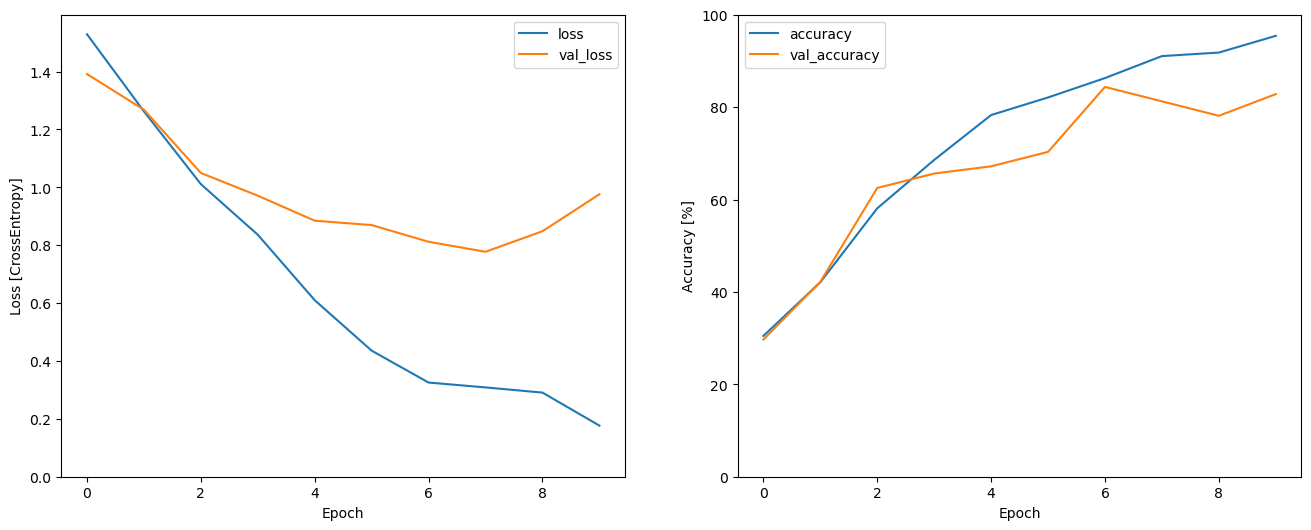

In [33]:
#Plotting Loss values for training and validation
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

#Plotting Accuracy values for training and validation
plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

## Step 6: Checkpoint!
<span style="color:Blue">Let's check out the prediction results for an audio sample, which does not exist in our dataset!</span>

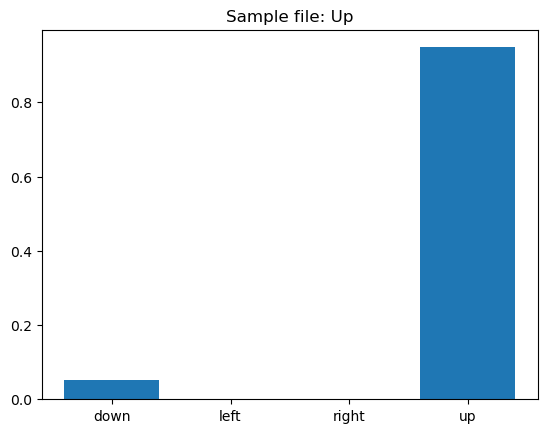

In [66]:
#Reading the test file and decode it using the desired lengths and sample rate, and number of channels
x = tf.io.read_file('msg-1840141157-39.wav')
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=3*16000)
#Squeezing to remove the extra axis
x = tf.squeeze(x, axis=-1)
waveform = x
#Getting the spectrogram from waveform
x = get_spectrogram(x)
x = x[tf.newaxis,...]

#Predict the command, using our trained model
prediction = model(x)

#Plotting the results as a bar chart
x_labels = ['down', 'left', 'right', 'up']
plt.bar(x_labels, tf.nn.softmax(prediction[0]))
plt.title('Sample file: Up')
plt.show()

#Displaying the original test sample, and the value of the predictions for each command label
display.display(display.Audio(waveform, rate=16000))
print(prediction)

## Step 7:
We evaluate the accuracy of the model, using our test data

In [36]:
model.evaluate(test_spectrogram_ds, return_dict=True)

3/3 [==============================] - 2s 327ms/step - loss: 0.6643 - accuracy: 0.7313


{'loss': 0.664343535900116, 'accuracy': 0.7313432693481445}

## Step 8:
Finally, we save the model to be used later. We can also export the directory of the saved model as a .zip file, to be later used outside the jupyter notebook.

In [37]:
model.save('saved_model_final')

INFO:tensorflow:Assets written to: saved_model_final\assets


INFO:tensorflow:Assets written to: saved_model_final\assets


## Part 3: Real-Time Command Recognition

## Step 1:
We define a function for preprocessing, which includes 3 steps:
1. The input waveform is first normalized to have values between -1 and 1 by dividing it by 32768.
2. The waveform is then converted to a TensorFlow tensor with a float32 data type.
3. The get_spectrogram function is called with the waveform as input to compute the spectrogram.
4. The resulting spectrogram tensor is then expanded with an additional dimension at the beginning to obtain a tensor of shape (1, height, width, channels).
5. Finally, the spectrogram tensor is returned as the output of the function.

In [38]:
def preprocess_audiobuffer(waveform):
    """
    waveform: ndarray of size (48000, )
    
    output: Spectogram Tensor of size: (1, `height`, `width`, `channels`)
    """
    #  normalizing from [-32768, 32767] to [-1, 1]
    waveform =  waveform / 32768

    #Converting the raw waveform to a tensor
    waveform = tf.convert_to_tensor(waveform, dtype=tf.float32)

    #Getting the spectogram from the waveform
    spectogram = get_spectrogram(waveform)
    
    # adding one dimension
    spectogram = tf.expand_dims(spectogram, 0)
    
    return spectogram

## Step 2:
This function is defined to be used to record audio from a microphone and retrieve the recorded audio as a NumPy array for further processing and analysis.

In [43]:
#Defining the size of buffer, channels, sampling rate and format
FRAMES_PER_BUFFER = 3200
FORMAT = pyaudio.paInt16
CHANNELS = 1
RATE = 16000
p = pyaudio.PyAudio()

def record_audio():
    stream = p.open(
        format=FORMAT,
        channels=CHANNELS,
        rate=RATE,
        input=True,
        frames_per_buffer=FRAMES_PER_BUFFER
    )

    ##

    frames = []
    seconds = 3
    #Reading data from stream for 3 seconds
    for i in range(0, int(RATE / FRAMES_PER_BUFFER * seconds)):
        data = stream.read(FRAMES_PER_BUFFER)
        frames.append(data)

    ##
    
    #Stopping the stream and closing it
    stream.stop_stream()
    stream.close()
    
    return np.frombuffer(b''.join(frames), dtype=np.int16)


def terminate():
    p.terminate()

## Step 3:
We use our trained model to the predict the command captured by the microphone. Then, we check the maximum predicted value and decide to do not do anything if this max value is lower than a certain threshold. However if the max predicted value is large and reliable enough, we print out the detected command label.

In [64]:
loaded_model = models.load_model("saved_model_final")

def predict_mic():
    #Getting Data from microphone, and preprocess it
    audio = record_audio()
    spec = preprocess_audiobuffer(audio)
    
    #Making the prediction, using our trained model
    prediction = loaded_model(spec)
    #print(prediction)
    
    #Checking if the prediction is reliable enough
    if np.max(prediction) > 18:
        label_pred = np.argmax(prediction, axis=1)
        #Printing the predicted command
        command = commands[label_pred[0]]
        print("Predicted label:", command)
    else:
        command = 0
    return command


## Step 4: The Final Experiment!

In [63]:
if __name__ == "__main__":
    try:
        while True:
            command = predict_mic()
    except KeyboardInterrupt:
        print('Interrupted')


Predicted label: down
Predicted label: right
Predicted label: right
Predicted label: up
Predicted label: right
Predicted label: left
Predicted label: down
Predicted label: left
Predicted label: up
Predicted label: down
Predicted label: down
Predicted label: down
Predicted label: down
Predicted label: right
Predicted label: down
Predicted label: down
Interrupted
